<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/add_classifier/P5_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data analysis and wrangling
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

# text
from gensim.models import LdaMulticore
from gensim.models import Phrases, CoherenceModel
from IPython.display import display, HTML

# Save objects
import joblib

# Set working directory
import time
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

# Data table display for Pandas dataframes
from google.colab import data_table
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Import

In [ ]:
corpus = joblib.load('corpus.sav')
dictionary = joblib.load('dictionary.sav')
df = joblib.load('df.sav')
texts_cleaned = joblib.load('texts_cleaned.sav')

# Modeling phase
In order to be able to categorize the questions of our corpus in an unsupervised way, we use Mallet's implementation of Latent Dirichlet Allocation (LDA). We train several models with a pre-indicated number of subjects around which to group documents, and look for the best according to the consistency value.

In [ ]:
# Initialization
start, limit, step = 8, 20, 2
coherence_values = []
model_list = []


# Processing
for num_topics in range(start, limit, step):
    start = time.time()

    model = LdaMulticore(corpus, id2word=dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencevalue = CoherenceModel(model=model, texts=texts_cleaned,
                                    dictionary=dictionary).get_coherence()
    coherence_values.append(coherencevalue)

    # display training information along the way
    minutes, seconds = divmod(time.time()-start, 60)

    str_perf = f"Nombre de topics: {num_topics:2} ... Valeur de coherence: {coherencevalue:.3} ... "
    str_time = f"Temps d'entrainement et d'évaluation: {round(minutes):2} minutes {round(seconds):2} secondes..."
    print(str_perf + str_time)

Nombre de topics:  8 ... Valeur de coherence: 0.507 ... Temps d'entrainement et d'évaluation:  4 minutes 10 secondes...
Nombre de topics: 10 ... Valeur de coherence: 0.496 ... Temps d'entrainement et d'évaluation:  4 minutes 14 secondes...
Nombre de topics: 12 ... Valeur de coherence: 0.521 ... Temps d'entrainement et d'évaluation:  4 minutes 17 secondes...
Nombre de topics: 14 ... Valeur de coherence: 0.508 ... Temps d'entrainement et d'évaluation:  4 minutes 19 secondes...
Nombre de topics: 16 ... Valeur de coherence: 0.516 ... Temps d'entrainement et d'évaluation:  4 minutes 19 secondes...
Nombre de topics: 18 ... Valeur de coherence: 0.509 ... Temps d'entrainement et d'évaluation:  4 minutes 23 secondes...


Let us represent graphically the evolution of coherence

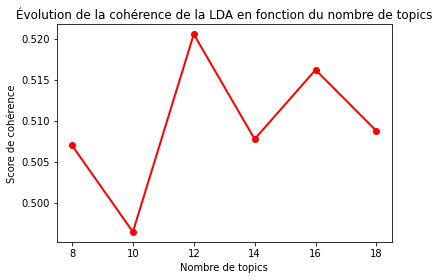

In [ ]:
n_topics = range(8, limit, step)
plt.plot(n_topics, coherence_values, 'r-', linewidth='2')
plt.plot(n_topics, coherence_values, 'ro', linewidth='5')
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
plt.title("Évolution de la cohérence de la LDA en fonction du nombre de topics");

# Results interpretation

We choose to keep the 10 topic model as the final model. Indeed, according to our evolution curve, we notice that the coherence value reaches a plateau from this value, and only deviates very slightly for the number of following topics.

In [ ]:
optimal_model = model_list[2]

joblib.dump(optimal_model, 'optimal_model.sav')

['optimal_model.sav']

For each topic that emerges, let's display the list of the most probable words.

In [ ]:
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i, topn=10)
    words = ', '.join([word for word, prob in desc])
    print(f'Topic #{i+1:2}:\n\t', words)

Topic # 1:
	 table, sql, database, query, column, array, row, character, convert, store
Topic # 2:
	 thread, service, unit, task, process, instance, django, lock, resource, spring
Topic # 3:
	 visual, exception, studio, system, log, debug, window, assembly, wpf, net
Topic # 4:
	 image, size, memory, css, large, space, color, take, game, background
Topic # 5:
	 python, command, script, window, directory, linux, windows, path, machine, folder
Topic # 6:
	 java, xml, eclipse, git, repository, module, plugin, svn, branch, commit
Topic # 7:
	 net, web, php, asp, http, com, site, url, mvc, api
Topic # 8:
	 iphone, android, date, google, device, email, xcode, datetime, library, apple
Topic # 9:
	 variable, language, java, difference, reference, parameter, compile, understand, compiler, define
Topic #10:
	 text, view, jquery, html, button, click, element, event, select, display
Topic #11:
	 request, client, send, javascript, browser, connection, message, header, json, response
Topic #12:
	 pro

For each document, let's find the topic that contributes the most to its distribution of words

In [ ]:
dominant_topics = []
perc_contributions = []

for predictions in optimal_model[corpus]:
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    topic_num, topic_contrib = predictions[0] # Get most contributing topic
    dominant_topics.append(int(topic_num+1))
    perc_contributions.append(round(topic_contrib, 4))
    
docs_dominants = pd.DataFrame({'Dominant Topic': dominant_topics,
                               'Contribution': perc_contributions,
                               'Index': texts_cleaned.index})
docs_dominants.set_index(['Index'], inplace=True)
docs_dominants

,Dominant Topic,Contribution
Index,,
10000005,1,0.8522
10000020,7,0.5548
10000074,9,0.5349
10000083,9,0.4916
10000226,1,0.5448
...,...,...
1213074,3,0.5742
1213127,2,0.4078
1213137,10,0.6802


With this new frame, let's try to segment our dataset by calculating:

1.   the number of documents per contributor top topic
2.   the proportion of documents by contributor top topic

In [ ]:
# Number of documents for each topic
docs_per_topic = (docs_dominants['Dominant Topic']
                  .value_counts(sort=False)
                  .to_frame()
                  .rename(columns={'Dominant Topic': 'Document count'})
                 )

# Proportion of documents for each topic
topic_props = (docs_per_topic.divide(docs_per_topic.sum())
               .round(4)
               .rename(columns={'Document count': 'Document proportion'})
              )

Let's attach this information with the descriptor keywords of the topics

In [ ]:
# Most probable keywords per topic
keywords = []
for i in range(optimal_model.num_topics):
    desc = optimal_model.show_topic(i)
    keywords.append(', '.join([word for word, prob in desc]))

num_topics = [i+1 for i in range(optimal_model.num_topics)]
df_topics_keywords = pd.DataFrame({'Topic #': num_topics, 'Keywords': keywords})
df_topics_keywords.set_index(['Topic #'], inplace=True)

# Final Frame
df_dominant_topics = df_topics_keywords.join([docs_per_topic, topic_props])
df_dominant_topics.sort_values(['Document proportion'], ascending=False, inplace=True)
df_dominant_topics

,Keywords,Document count,Document proportion
Topic #,,,
9,"variable, language, java, difference, referenc...",47986,0.1734
1,"table, sql, database, query, column, array, ro...",34066,0.1231
10,"text, view, jquery, html, button, click, eleme...",32724,0.1183
5,"python, command, script, window, directory, li...",24865,0.0899
4,"image, size, memory, css, large, space, color,...",19865,0.0718
7,"net, web, php, asp, http, com, site, url, mvc,...",18523,0.0669
11,"request, client, send, javascript, browser, co...",17861,0.0646
2,"thread, service, unit, task, process, instance...",17672,0.0639
6,"java, xml, eclipse, git, repository, module, p...",17285,0.0625


In more detail, we will take here several examples to which we will suggest tags. To do this, we will search among the key words characteristic of the dominant topic of the said example those which appear there. These examples that we select are considered to be the most representative of each area.

In [ ]:
top_categories = (docs_dominants.sort_values(['Contribution'],ascending=False)
                  .groupby(['Dominant Topic'], sort=False)
                  .head(1)
                  .sort_values(['Dominant Topic'])
                  .reset_index().set_index(['Dominant Topic'])
                 )

examples = (top_categories
            .join(corpus.apply(len).to_frame('Length'), 'Index')
            .sort_values('Length', ascending=False).Index)

def show_example(corpus, lemmas, data, examples, model, n_ex):
    predictions = model[corpus[examples.iloc[n_ex]]]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    topic_num, topic_contrib = predictions[0]
    desc = optimal_model.show_topic(topic_num, topn=20)
    
    keywords = [word for word, prob in desc]
    tags = {lemma for lemma in lemmas[examples.iloc[n_ex]] if lemma in keywords}

    display(HTML(data.loc[examples.iloc[n_ex], 'Body']))
    print("-"*30, '\nTags proposés: ')
    print(tags)


show_example(corpus, texts_cleaned, df, examples, optimal_model, 4)

------------------------------ 
Tags proposés: 
{'row', 'search', 'column', 'index'}
